**Resume Information Extractor**

# A Comprehension of Intelligent Document Processing

Intelligent Document Processing (IDP) is an advanced automation technology that transforms the way businesses handle documents. By leveraging artificial intelligence (AI), IDP systems can automatically read, understand, and process vast quantities of documents, extracting crucial data and feeding it into various business workflows. This technology is a significant leap from traditional Optical Character Recognition (OCR) as it not only digitizes text but also comprehends the context and structure of the information within documents.

At its core, IDP is designed to tackle the challenge of processing unstructured and semi-structured data, which make up a large portion of business documents such as invoices, contracts, emails, and forms. By automating the extraction and interpretation of this data, IDP significantly reduces the need for manual data entry, leading to increased efficiency, higher accuracy, and substantial cost savings.

<br><br>

---
<br><br>

### The Inner Workings of Intelligent Document Processing

The power of IDP lies in its sophisticated multi-step process that intelligently handles documents from ingestion to data delivery. This process typically involves several key stages:

**1. Document Ingestion:** The first step involves importing documents from various sources and in multiple formats, including scanned paper documents, PDFs, Word files, and images.

**2. Pre-processing:** To enhance the quality of the input, documents undergo a pre-processing stage. This includes techniques like noise reduction, image enhancement, and deskewing to improve the accuracy of subsequent data extraction.

**3. Document Classification:** Using machine learning algorithms, the IDP system automatically categorizes documents based on their layout and content. This allows the system to differentiate between an invoice, a purchase order, or a legal contract, for instance.

**4. Data Extraction:** This is the core function of IDP. Advanced AI technologies, including Natural Language Processing (NLP) and computer vision, are employed to identify and extract relevant data fields. For example, from an invoice, it can pull out the invoice number, date, vendor name, and line-item details.

**5. Data Validation:** The extracted data is then validated against predefined rules and existing databases to ensure accuracy and consistency. Any exceptions or discrepancies can be flagged for human review in a "human-in-the-loop" process, which also helps to train and improve the AI model over time.

**6. Integration:** Finally, the structured and validated data is seamlessly integrated into downstream business systems such as Enterprise Resource Planning (ERP), Customer Relationship Management (CRM), or other databases, making the information readily available for further processing and analysis.


From **finance departments** automating invoice processing and expense management to **healthcare organizations** streamlining patient record management and claims processing, IDP is proving to be a game-changer. Even  **human resources** can expedite resume screening and employee onboarding. As the technology continues to evolve, its applications are expected to expand even further, solidifying its role as a cornerstone of modern digital transformation.

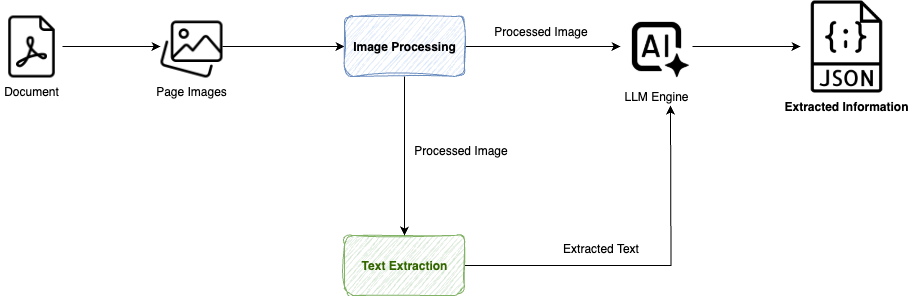

In [1]:
! pip install opencv-python matplotlib numpy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#display image
import cv2
import numpy as np
import matplotlib.pyplot as plt


def display_image(image,title="Image"):
  plt.figure(figsize=(7,7))
  plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
  plt.title(title)
  plt.axis('off')
  plt.show()



In [4]:
#convert to grayscale
def convert_to_grayscale(image):
  return cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

In [5]:
#reduce noise
def reduce_noise(image):
  return cv2.GaussianBlur(image,(5,5),0)

In [6]:
def deskew_image(image):
    """
    Corrects the skew of an image by finding the minimum area rectangle
    of the text block and rotating accordingly.
    """
    # Find all non-zero (white) pixels
    coords = cv2.findNonZero(image)

    # Get the minimum area bounding rectangle
    # It returns (center(x,y), (width, height), angle of rotation)
    rect = cv2.minAreaRect(coords)
    angle = rect[-1] - 90

    # The `cv2.minAreaRect` angle has a specific range.
    # We need to adjust it for our rotation.
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = angle

    # Get the rotation matrix and rotate the image
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
                             flags=cv2.INTER_CUBIC,
                             borderMode=cv2.BORDER_REPLICATE)
    print(f"Detected skew angle: {angle:.2f} degrees")

    # Now, rotate the original grayscale image by the same angle
    (h, w) = rotated.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    deskewed_gray = cv2.warpAffine(rotated, M, (w, h),
                                  flags=cv2.INTER_CUBIC,
                                  borderMode=cv2.BORDER_REPLICATE)

    return deskewed_gray

In [7]:
def binarize_image(blur_reduced_image):
  return cv2.adaptiveThreshold(
    blur_reduced_image,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, # Invert the colors (text becomes white)
    11, # Block size
    4  # Constant C
  )

In [8]:
def process_one_image(image):
  image = convert_to_grayscale(image)
  print("Converted image to grayscale..")
  image = reduce_noise(image)
  print("Reduced noise in the image..")
  image = binarize_image(image)
  print("Binarized the image..")
  image = deskew_image(image)
  print("Corrected image orientation..")
  return image

In [9]:
! pip install pytesseract pillow

In [10]:
#start with pdf conversion to image so that we can extract the info from and
#send it to llm and also use textract to validate the output and get it in form of json as output

In [11]:
!pip install pdf2image
!sudo apt-get install -y poppler-utils   # required on Linux/Colab


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.10 [186 kB]
Fetched 186 kB in 0s (1,028 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 1264

In [12]:
from pdf2image import convert_from_path
import cv2
import numpy as np
import os
import time

# Input folder containing PDF resumes
input_pdf_path = "/content/drive/MyDrive/TEACHER"
# Output folder for extracted images
output_folder_path = "/content/processed_pdf"

start_time = time.time()

# Create output folder if not exists
os.makedirs(output_folder_path, exist_ok=True)
print(f"Saving converted images to: {output_folder_path}")

# Loop through first 10 PDFs
for pdf_file in os.listdir(input_pdf_path)[:10]:
    if pdf_file.lower().endswith(".pdf"):
        pdf_path = os.path.join(input_pdf_path, pdf_file)
        print(f"Converting PDF to images: {pdf_file}")

        # Convert all pages in PDF → list of PIL images
        pages = convert_from_path(pdf_path, dpi=300)

        for page_num, page in enumerate(pages, start=1):
            # Convert PIL → OpenCV (BGR)
            img = cv2.cvtColor(np.array(page), cv2.COLOR_RGB2BGR)

            # OPTIONAL preprocessing
            # img = process_one_image(img)

            # Save each page separately
            pdf_name = os.path.splitext(pdf_file)[0]
            output_filename = f"{pdf_name}_page{page_num}.png"
            output_path = os.path.join(output_folder_path, output_filename)
            cv2.imwrite(output_path, img)

            print(f"✅ Saved page {page_num} of {pdf_file} → {output_filename}")

        print("-" * 50)

print("🎉 All PDFs processed.")
print(f"⏱️ Total time taken: {time.time() - start_time:.2f} seconds")


Saving converted images to: /content/processed_pdf
Converting PDF to images: 10527994.pdf
✅ Saved page 1 of 10527994.pdf → 10527994_page1.png
--------------------------------------------------
Converting PDF to images: 13583538.pdf
✅ Saved page 1 of 13583538.pdf → 13583538_page1.png
✅ Saved page 2 of 13583538.pdf → 13583538_page2.png
--------------------------------------------------
Converting PDF to images: 21531811.pdf
✅ Saved page 1 of 21531811.pdf → 21531811_page1.png
--------------------------------------------------
Converting PDF to images: 45286020.pdf
✅ Saved page 1 of 45286020.pdf → 45286020_page1.png
✅ Saved page 2 of 45286020.pdf → 45286020_page2.png
--------------------------------------------------
Converting PDF to images: 27126818.pdf
✅ Saved page 1 of 27126818.pdf → 27126818_page1.png
✅ Saved page 2 of 27126818.pdf → 27126818_page2.png
✅ Saved page 3 of 27126818.pdf → 27126818_page3.png
--------------------------------------------------
Converting PDF to images: 22632

In [13]:
#use textxtract to extract
from PIL import Image
import pytesseract
import time

input_folder_path = "/content/processed_pdf"
output_folder_path = "/content/tesseract_output"
start_time = time.time()

if os.makedirs(output_folder_path, exist_ok=True):
  print(f"Created folder: {output_folder_path}")

total_images = sum(1 for entry in os.scandir(input_folder_path))
print(f"Total images in folder: {total_images}")

for i, image_name in enumerate(os.listdir(input_folder_path)[:20], 1):
  print(f"Processing image {i}/{total_images}: {image_name}")
  image_path = os.path.join(input_folder_path, image_name)
  print("Extracting text from image..")
  text = pytesseract.image_to_string(Image.open(image_path))
  output_path = os.path.join(output_folder_path, os.path.splitext(image_name)[0] + ".txt")

  with open(output_path, "w") as f:
    f.write(text)

  print(f"Saved extracted text to {output_path}")
  print("-"*50)

print("Text Extraction Completed.")
print(f"Total time taken: {time.time() - start_time} seconds")

Total images in folder: 16
Processing image 1/16: 19464810_page2.png
Extracting text from image..
Saved extracted text to /content/tesseract_output/19464810_page2.txt
--------------------------------------------------
Processing image 2/16: 21531811_page1.png
Extracting text from image..
Saved extracted text to /content/tesseract_output/21531811_page1.txt
--------------------------------------------------
Processing image 3/16: 22807104_page2.png
Extracting text from image..
Saved extracted text to /content/tesseract_output/22807104_page2.txt
--------------------------------------------------
Processing image 4/16: 13583538_page1.png
Extracting text from image..
Saved extracted text to /content/tesseract_output/13583538_page1.txt
--------------------------------------------------
Processing image 5/16: 10527994_page1.png
Extracting text from image..
Saved extracted text to /content/tesseract_output/10527994_page1.txt
--------------------------------------------------
Processing image 6

In [14]:
prompt = """
Extract the following structured information from the given resume text.

Fields to extract:
{
    "Name": "",
    "Email": "",
    "Phone": "",
    "Address": "",
    "Summary": "",
    "Experience": "",
    "Education": "",
    "Skills": "",
}

Notes:
- The resume may have multiple sections (summary, work experience, education, skills, etc.).
- If some information is missing, leave the value as an empty string "".
- Ensure the output is valid JSON only, no extra commentary.
- Correct formatting issues if the OCR text has mistakes (e.g., extra line breaks, typos).
- Do not add fields that are not listed above.
- Also summarized the summary and experience section within 30 words including job role and work esperience.

Here is the OCR-extracted text from the resume:

{text}
"""


In [15]:
from google import genai
from google.colab import userdata # colab only code
from PIL import Image
import json
import time

In [16]:
# Used to securely store your API key
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')


In [26]:
import google.generativeai as genai
from google.colab import userdata  # Colab only
import json
import time
import os

# Initialize GenAI client
genai.configure(api_key=userdata.get("GOOGLE_API_KEY"))

image_folder_path = "/content/processed_pdf"
text_folder_path = "/content/tesseract_output"
output_folder_path = "/content/json_output"

start_time = time.time()
os.makedirs(output_folder_path, exist_ok=True)

print(f"Saving JSON outputs to: {output_folder_path}")

# --- Step 1: Group resumes by prefix ---
resume_groups = {}
for file in os.listdir(image_folder_path):
    if file.lower().endswith(".png"):  # only process PNG images
        resume_id = file.split("_page")[0]   # e.g. "19464810"
        resume_groups.setdefault(resume_id, []).append(file)

print(f"Found {len(resume_groups)} resumes.")

# --- Step 2: Process each resume ---
for i, (resume_id, pages) in enumerate(resume_groups.items(), 1):
    print(f"\nProcessing resume {i}/{len(resume_groups)}: {resume_id}")

    # Sort pages to keep order
    pages.sort()

    # Merge all page texts
    full_text = ""
    for page_file in pages:
        # ✅ Correct filename: resumeID_pageX.txt
        text_file = os.path.splitext(page_file)[0] + ".txt"
        text_path = os.path.join(text_folder_path, text_file)
        if not os.path.exists(text_path):
            print(f"⚠️ Missing OCR text file: {text_path}")
            continue
        with open(text_path, "r", encoding="utf-8") as f:
            full_text += f"\n--- Page: {page_file} ---\n" + f.read()

    # Skip if no text
    if not full_text.strip():
        print(f"⚠️ No text found for {resume_id}, skipping.")
        continue

    # --- Step 3: Build prompt ---
    prompt = f"""
Extract the following structured information from the given resume text.

Fields to extract:
{{
    "Name": "",
    "Email": "",
    "Phone": "",
    "Address": "",
    "Summary": "",
    "Experience": "",
    "Education": "",
    "Skills": "",
    "Summarized_Summary_and_Experience": ""
}}

Notes:
- The resume may have multiple sections (summary, work experience, education, skills, etc.).
- If some information is missing, leave the value as an empty string "".
- Ensure the output is valid JSON only, no extra commentary.
- Correct formatting issues if the OCR text has mistakes (e.g., extra line breaks, typos).
- Do not add fields that are not listed above.
- Also summarize the summary and experience section within 30 words including job role and work experience into the field "Summarized_Summary_and_Experience".

Here is the OCR-extracted text from the resume:

{full_text}
"""

    print("Sending to Gemini API...")

    try:
        model = genai.GenerativeModel("gemini-1.5-flash")  # safer, newer model
        response = model.generate_content(prompt)
        # --- Step 4: Parse JSON ---
        extracted_info = json.loads(
            response.text.strip().replace("```json", "").replace("```", "")
        )

        # Save JSON output
        output_path = os.path.join(output_folder_path, f"{resume_id}.json")
        with open(output_path, "w", encoding="utf-8") as f:
            json.dump(extracted_info, f, indent=4)

        print(f"✅ Saved extracted info for {resume_id} → {output_path}")
        time.sleep(1)  # avoid API rate limit

    except Exception as e:
        print(f"⚠️ Error processing {resume_id}: {e}")
        error_output_path = os.path.join(output_folder_path, f"{resume_id}_error.txt")
        with open(error_output_path, "w", encoding="utf-8") as f:
            f.write(f"Error: {e}\n")
            if "response" in locals() and hasattr(response, "text"):
                f.write(f"Response Text: {response.text}\n")


print("\n🎉 Completed all resumes.")
print(f"⏱️ Total time: {time.time() - start_time:.2f} seconds")

Saving JSON outputs to: /content/json_output
Found 10 resumes.

Processing resume 1/10: 19464810
Sending to Gemini API...
✅ Saved extracted info for 19464810 → /content/json_output/19464810.json

Processing resume 2/10: 21531811
Sending to Gemini API...
✅ Saved extracted info for 21531811 → /content/json_output/21531811.json

Processing resume 3/10: 22807104
Sending to Gemini API...
✅ Saved extracted info for 22807104 → /content/json_output/22807104.json

Processing resume 4/10: 13583538
Sending to Gemini API...
✅ Saved extracted info for 13583538 → /content/json_output/13583538.json

Processing resume 5/10: 10527994
Sending to Gemini API...
✅ Saved extracted info for 10527994 → /content/json_output/10527994.json

Processing resume 6/10: 22632070
Sending to Gemini API...
✅ Saved extracted info for 22632070 → /content/json_output/22632070.json

Processing resume 7/10: 45286020
Sending to Gemini API...
✅ Saved extracted info for 45286020 → /content/json_output/45286020.json

Processing r

ERROR:tornado.access:503 POST /v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 557.41ms


✅ Saved extracted info for 13855004 → /content/json_output/13855004.json

Processing resume 10/10: 17311685
Sending to Gemini API...
✅ Saved extracted info for 17311685 → /content/json_output/17311685.json

🎉 Completed all resumes.
⏱️ Total time: 84.74 seconds


In [25]:
pip install --upgrade google-generativeai


Displaying output for: 21531811.json
Extracted JSON Data:
{
    "Name": "PRESCHOOL TEACHER",
    "Email": "",
    "Phone": "",
    "Address": "",
    "Summary": "Enthusiastic Preschool Teacher talented at teaching visual art, music and theater. Engages children with diverse and enjoyable activities involving theatrical play, musical instruments and hands-on learning.",
    "Experience": "August 2015 to Current\nCompany Name City , State Preschool Teacher\n\n Provide a variety of materials and resources for children to explore, manipulate and use, both in learning activities and in imaginative play.\n Attend to children's basic needs by feeding them, dressing them, and changing their diapers.\n Teach basic skills such as color, shape, number and letter recognition, personal hygiene, and social skills.\n Establish and enforce rules for behavior, and procedures for mamtainmng order.\n Read books to entire classes or to small groups.\n Organize and lead activities designed to promote physi

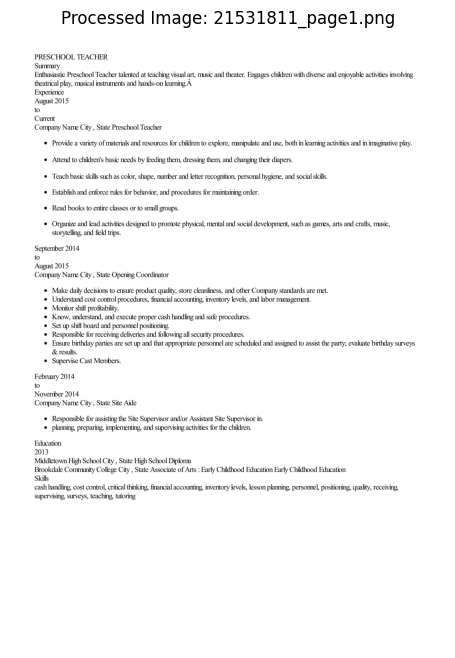

In [27]:
import json
import os
import cv2
import matplotlib.pyplot as plt

json_output_folder = "/content/json_output"
processed_image_folder = "/content/processed_pdf"

# Get a list of JSON files in the output folder
json_files = [f for f in os.listdir(json_output_folder) if f.endswith('.json')]

if not json_files:
    print("No JSON files found in the output folder.")
else:
    # Take the first JSON file as an example
    sample_json_file = json_files[0]
    sample_resume_id = os.path.splitext(sample_json_file)[0]
    sample_json_path = os.path.join(json_output_folder, sample_json_file)

    print(f"Displaying output for: {sample_json_file}")

    # Load and display the JSON content
    with open(sample_json_path, 'r') as f:
        extracted_data = json.load(f)
    print("Extracted JSON Data:")
    print(json.dumps(extracted_data, indent=4))

    # Find and display the corresponding processed image(s)
    print("\nCorresponding Processed Image(s):")
    image_files = [f for f in os.listdir(processed_image_folder) if f.startswith(sample_resume_id) and f.endswith('.png')]
    image_files.sort() # Display pages in order

    if not image_files:
        print(f"No processed image files found for resume ID: {sample_resume_id}")
    else:
        for image_file in image_files:
            image_path = os.path.join(processed_image_folder, image_file)
            try:
                image = cv2.imread(image_path)
                if image is not None:
                    plt.figure(figsize=(8, 8))
                    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                    plt.title(f"Processed Image: {image_file}")
                    plt.axis('off')
                    plt.show()
                else:
                    print(f"Could not load image: {image_file}")
            except Exception as e:
                print(f"Error displaying image {image_file}: {e}")